# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import pandas as pd

import core.config.config_ as cconconf
import core.plotting.normality as cplonorm
import core.plotting.plotting_utils as cplpluti
import helpers.hdbg as hdbg
import helpers.hprint as hprint
import research_amp.transform as ramptran

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-35ea7862-4cee-4940-95dd-fda4e51ec81b.json'


# Config

In [3]:
def get_cmtask1704_config_crypto_chassis() -> cconconf.Config:
    """
    Get config, that specifies params for getting raw data from `crypto
    chassis`.
    """
    config = cconconf.Config()
    # Load parameters.
    # config.add_subconfig("load")
    # Data parameters.
    config.add_subconfig("data")
    config["data"]["full_symbols"] = [
        "binance::ADA_USDT",
        "binance::BNB_USDT",
        "binance::BTC_USDT",
        "binance::DOGE_USDT",
        "binance::EOS_USDT",
        "binance::ETH_USDT",
        "binance::SOL_USDT",
        "binance::XRP_USDT",
        "binance::LUNA_USDT",
        "binance::DOT_USDT",
        "binance::LTC_USDT",
        "binance::UNI_USDT",
    ]
    config["data"]["start_date"] = pd.Timestamp("2022-01-01", tz="UTC")
    config["data"]["end_date"] = pd.Timestamp("2022-02-01", tz="UTC")
    # Transformation parameters.
    config.add_subconfig("transform")
    config["transform"]["resampling_rule"] = "5T"
    config["transform"]["rets_type"] = "pct_change"
    return config

In [4]:
config = get_cmtask1704_config_crypto_chassis()
print(config)

data:
  full_symbols: ['binance::ADA_USDT', 'binance::BNB_USDT', 'binance::BTC_USDT', 'binance::DOGE_USDT', 'binance::EOS_USDT', 'binance::ETH_USDT', 'binance::SOL_USDT', 'binance::XRP_USDT', 'binance::LUNA_USDT', 'binance::DOT_USDT', 'binance::LTC_USDT', 'binance::UNI_USDT']
  start_date: 2022-01-01 00:00:00+00:00
  end_date: 2022-02-01 00:00:00+00:00
transform:
  resampling_rule: 5T
  rets_type: pct_change


Note: `exchange_id = binance` was chosen for coins v5 analysis.
The missing coins in crypto-chassis in `binance`:
- v4:
   - Avalanche (AVAX)
   - Chainlink (LINK)
- v5:
   - HEX
   - SHIB (Shiba Inu)
   - MATIC (Polygon)
   - TRX (TRON)
   - WAVES (Waves)
   - XLM (Stellar)

# Load OHLCV data from `crypto-chassis`

## Data demonstration

In [5]:
# TODO(Max): Refactor the loading part once #1766 is implemented.

# Read from crypto_chassis directly.
# full_symbols = config["data"]["full_symbols"]
# start_date = config["data"]["start_date"]
# end_date = config["data"]["end_date"]
# ohlcv_cc = raccchap.read_crypto_chassis_ohlcv(full_symbols, start_date, end_date)

# Read saved 1 month of data.
ohlcv_cc = pd.read_csv("/shared_data/ohlcv_cc_v5.csv", index_col="timestamp")
ohlcv_cc.index = pd.to_datetime(ohlcv_cc.index)
ohlcv_cc.head(3)

,open,high,low,close,volume,vwap,number_of_trades,twap,full_symbol
timestamp,,,,,,,,,
2022-01-01 00:00:00+00:00,1.308,1.310,1.307,1.310,98266.8,1.30843,64.0,1.30875,binance::ADA_USDT
2022-01-01 00:01:00+00:00,1.310,1.314,1.308,1.312,132189.4,1.31070,69.0,1.31090,binance::ADA_USDT
2022-01-01 00:02:00+00:00,1.312,1.318,1.311,1.317,708964.2,1.31589,273.0,1.31600,binance::ADA_USDT


# Calculate VWAP, TWAP and returns in `Dataflow` style

In [6]:
# VWAP, TWAP transformation.
resampling_rule = config["transform"]["resampling_rule"]
vwap_twap_df = ramptran.calculate_vwap_twap(ohlcv_cc, resampling_rule)

# Returns calculation.
rets_type = config["transform"]["rets_type"]
vwap_twap_rets_df = ramptran.calculate_returns(vwap_twap_df, rets_type)

,open,high,low,close,volume,vwap,number_of_trades,twap,full_symbol
timestamp,,,,,,,,,
2022-01-01 00:00:00+00:00,1.308,1.310,1.307,1.310,98266.8,1.30843,64.0,1.30875,binance::ADA_USDT
2022-01-01 00:01:00+00:00,1.310,1.314,1.308,1.312,132189.4,1.31070,69.0,1.31090,binance::ADA_USDT
2022-01-01 00:02:00+00:00,1.312,1.318,1.311,1.317,708964.2,1.31589,273.0,1.31600,binance::ADA_USDT
2022-01-01 00:03:00+00:00,1.317,1.317,1.315,1.315,219213.9,1.31607,79.0,1.31630,binance::ADA_USDT
2022-01-01 00:04:00+00:00,1.316,1.316,1.314,1.314,50590.0,1.31498,39.0,1.31500,binance::ADA_USDT


close                                                                                                                                                                                                                      high                                                                                                                                                                                                                       low                                                                                                                                                                                                          number_of_trades                                                                                                                                                                                                                      open                                                                                                                                                                                                                      twap                                                                                                                                                                                                                    volume                                                                                                                                                                                                                      vwap                                                                                                                                                                                                        
                          binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [7]:
# Show the snippet.
vwap_twap_rets_df.head(3)

close.ret_0                                                                                                                                                                                                                twap.ret_0                                                                                                                                                                                                                vwap.ret_0                                                                                                                                                                                                                     close                                                                                                                                                                                                                      twap                                                                           \
                          binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2022-01-01 00:00:00+00:00               NaN               NaN               NaN                NaN               NaN               NaN               NaN               NaN                NaN               NaN               NaN               NaN               NaN               NaN               NaN                NaN               NaN               NaN               NaN               NaN                NaN               NaN               NaN               NaN               NaN               NaN               NaN                NaN               NaN               NaN               NaN               NaN                NaN               NaN               NaN               NaN             1.310             512.2          46250.00             0.1704             26.72             3.035           3684.84             146.3              85.67            170.14             17.04            0.8314            1.3100            512.20         46250.000            0.17040            26.720   
2022-01-01 00:05:00+00:00          0.006107          0.002733   

,close.ret_0,twap.ret_0,vwap.ret_0
close.ret_0,1.000000,0.702098,0.826158
twap.ret_0,0.702098,1.000000,0.911829
vwap.ret_0,0.826158,0.911829,1.000000


<AxesSubplot:xlabel='timestamp'>

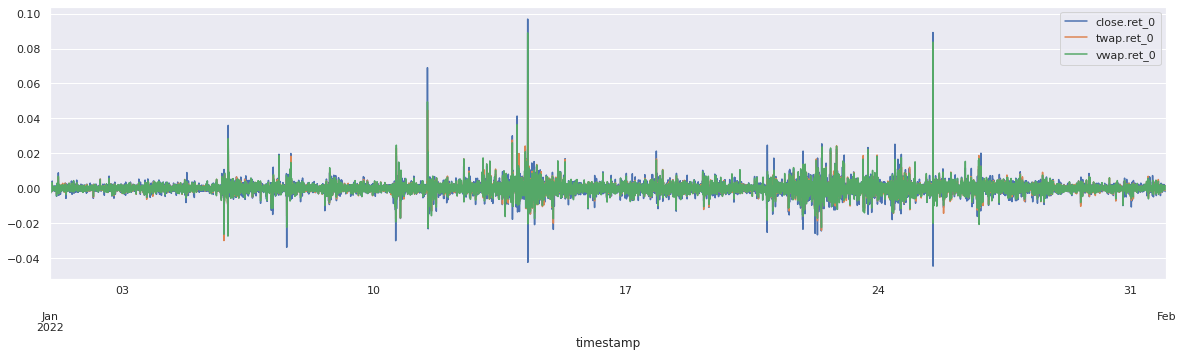

In [8]:
# Stats and vizualisation to check the outcomes.
coin_ex = vwap_twap_rets_df.swaplevel(axis=1)
coin_ex = coin_ex["binance::DOGE_USDT"][
    ["close.ret_0", "twap.ret_0", "vwap.ret_0"]
]
display(coin_ex.corr())
coin_ex.plot()

# Bid-ask data

In [9]:
# TODO(Max): Refactor the loading part once #1766 is implemented.

# Read from crypto_chassis directly.
# Specify the params.
# full_symbols = config["data"]["full_symbols"]
# start_date = config["data"]["start_date"]
# end_date = config["data"]["end_date"]
# Get the data.
# bid_ask_df = raccchap.read_and_resample_bid_ask_data(
#    full_symbols, start_date, end_date, "5T"
# )
# bid_ask_df.head(3)

# Read saved 1 month of data.
bid_ask_df = pd.read_csv(
    "/shared_data/bid_ask_data_v5.csv", index_col="timestamp"
)
bid_ask_df.index = pd.to_datetime(bid_ask_df.index)
bid_ask_df.head(3)

,bid_price,bid_size,ask_price,ask_size,full_symbol
timestamp,,,,,
2022-01-01 00:00:00+00:00,1.307000,39661.5,1.308000,13111.0,binance::ADA_USDT
2022-01-01 00:05:00+00:00,1.312217,11109534.6,1.313217,10411351.4,binance::ADA_USDT
2022-01-01 00:10:00+00:00,1.316537,12850507.0,1.317537,10603985.3,binance::ADA_USDT


In [10]:
# Calculate bid-ask metrics.
bid_ask_df = ramptran.calculate_bid_ask_statistics(bid_ask_df)
bid_ask_df.tail(3)

,bid_price,bid_size,ask_price,ask_size,full_symbol
timestamp,,,,,
2022-01-01 00:00:00+00:00,1.307000,39661.5,1.308000,13111.0,binance::ADA_USDT
2022-01-01 00:05:00+00:00,1.312217,11109534.6,1.313217,10411351.4,binance::ADA_USDT
2022-01-01 00:10:00+00:00,1.316537,12850507.0,1.317537,10603985.3,binance::ADA_USDT
2022-01-01 00:15:00+00:00,1.315423,13029688.7,1.316426,10712328.1,binance::ADA_USDT
2022-01-01 00:20:00+00:00,1.316167,12234938.6,1.317171,12718330.6,binance::ADA_USDT


ask_price                                                                                                                                                                                                                  ask_size                                                                                                                                                                                                                 bid_price                                                                                                                                                                                                                  bid_size                                                                                                                                                                                                        
                          binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2022-01-01 00:00:00+00:00          1.308000        511.500000      46214.020000           0.170300         26.680000          3.034000       3676.550000        146.300000          85.520000        170.010000         17.010000          0.829800           13111.0            19.191           0.24793             1427.0            336.64             610.1            8.0549           205.994               4.93              1.79            639.73            1330.0          1.307000        511.400000      46214.010000           0.170200         26.670000          3.033000       3676.540000        146.200000          85.500000        170.000000         17.000000          0.829700           39661.5           100.147           1.08286           132855.0             51.67            2409.9            3.7000            99.731               5.07             17.99            138.90             299.0
2022-01-01 00:05:00+00:00          1.313217        512.770707      46306.801533           0.170767         26.762708          3.041139       3688.311338        146.451880          85.682818        170.327829         17.076468          0.832946        10411351.4         18144.268         207.40103         44832479.0         102696.36          386624.8         1102.0388         58806.210           20231.26           4372.88         142098.6

ask_value                                                                                                                                                                                                                 bid_value                                                                                                                                                                                                         centered_order_book_imbalance                                                                                                                                                                                                             geometric_mid                                                                                                                                                                                                         log_order_book_imbalance                                                         \
                          binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT             binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT        binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2022-01-31 23:50:00+00:00      2.610956e+07      9.873797e+06      1.316166e+07       1.120212e+07      6.877507e+06      1.485589e+06      2.983609e+06      1.676512e+07       7.077981e+06      1.802051e+06      2.592089e+06      2.642678e+06      2.738044e+07      1.118830e+07      9.090482e+06       8.376078e+06      6.912250e+06      2.617529e+06      3.262962e+06      7.833298e+06       1.128518e+06     556493.239945      2.665624e+06      1.201462e+06                      0.024235          0.062543         -0.182957          -0.144001          0.002778          0.276071          0.044727         -0.362709          -0.724918         -0.528059          0.014440         -0.374842          1.049678        375.952362      38368.959080           0.141686         19.358451          2.336488       2681.911774        109.342085          51.547969         99.433214         11.816888          0.618258                 0.048480          0.125250         -0.370080          -0.290018   
2022-01-31 23:55:00+00:00      4.372091e+07      8.649485e+06 

## Unite VWAP, TWAP, rets statistics with bid-ask stats

In [11]:
final_df = pd.concat([vwap_twap_rets_df, bid_ask_df], axis=1)
final_df.tail(3)

close.ret_0                                                                                                                                                                                                                twap.ret_0                                                                                                                                                                                                                vwap.ret_0                                                                                                                                                                                                                     close                                                                                                                                                                                                                      twap                                                                           \
                          binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2022-01-31 23:50:00+00:00          0.000953          0.002130          0.001741           0.000706          0.000000         -0.000855          0.001846          0.000000           0.003293          0.000904          0.003396          0.000323          0.000190      2.612080e-03         -0.000043           0.001413          0.000517         -0.000855          0.000709          0.000000           0.001475          0.001067          0.006980         -0.002646          0.000101          0.002406         -0.000139           0.001203          0.000214         -0.000756          0.001776         -0.000148           0.000281          0.001201          0.006399         -0.001942             1.050             376.3          38441.04             0.1417             19.37             2.336           2686.25             109.4              51.80             99.61             11.82            0.6185            1.0502            376.16         38385.096            0.14170            19.360   
2022-01-31 23:55:00+00:00          0.002857         -0.002657   

<AxesSubplot:xlabel='timestamp'>

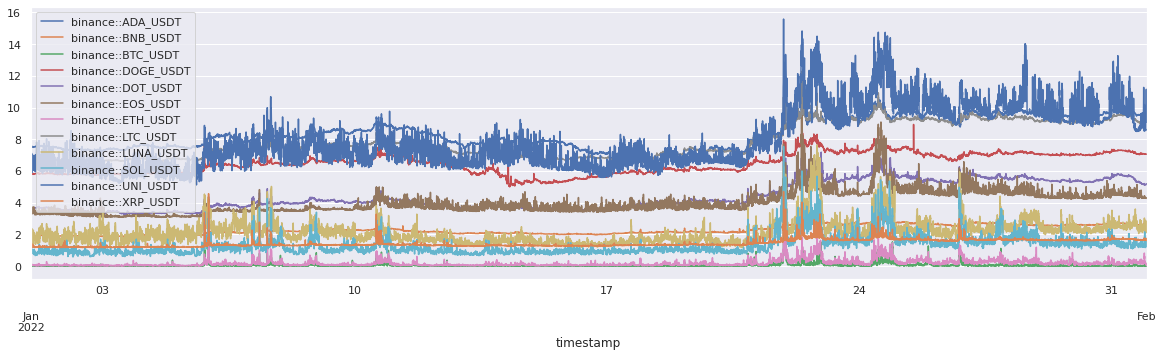

In [12]:
# Metrics visualizations.
final_df["relative_spread_bps"].plot()

## Compute the distribution of (return - spread)

In [13]:
# Choose the specific `full_symbol`.
df_bnb = final_df.swaplevel(axis=1)["binance::BNB_USDT"]
df_bnb.head(3)

,close.ret_0,twap.ret_0,vwap.ret_0,close,twap,volume,vwap,ask_value,bid_value,centered_order_book_imbalance,geometric_mid,log_order_book_imbalance,log_relative_spread,mid,mid_value,order_book_imbalance,quoted_spread,relative_spread_bps,weighted_mid,ask_price,ask_size,bid_price,bid_size
timestamp,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,NaN,NaN,NaN,512.2,512.20,423.922,512.200000,9.816197e+03,5.121518e+04,0.678376,511.449998,1.652198,0.000196,511.450000,3.051569e+04,0.839188,0.100000,1.955225,511.483919,511.500000,19.191,511.40000,100.147
2022-01-01 00:05:00+00:00,0.002733,0.001952,0.001984,513.6,513.20,2393.343,513.216045,9.303849e+06,8.933841e+06,-0.020190,512.720536,-0.040386,0.000196,512.720539,9.118845e+06,0.489905,0.100337,1.956947,512.719526,512.770707,18144.268,512.67037,17426.092
2022-01-01 00:10:00+00:00,0.000000,0.000624,0.000720,513.6,513.52,1433.895,513.585325,1.194030e+07,8.715529e+06,-0.156024,513.345957,-0.314618,0.000195,513.345960,1.032791e+07,0.421988,0.100000,1.948004,513.338158,513.395960,23257.482,513.29596,16979.540


In [14]:
# Calculate (|returns| - spread) and display descriptive stats.
df_bnb["ret_spr_diff"] = abs(df_bnb["close.ret_0"]) - (
    df_bnb["quoted_spread"] / df_bnb["close"]
)
display(df_bnb["ret_spr_diff"].describe())

count    8928.000000
mean        0.001529
std         0.002078
min        -0.000295
25%         0.000263
50%         0.000966
75%         0.002033
max         0.031095
Name: ret_spr_diff, dtype: float64

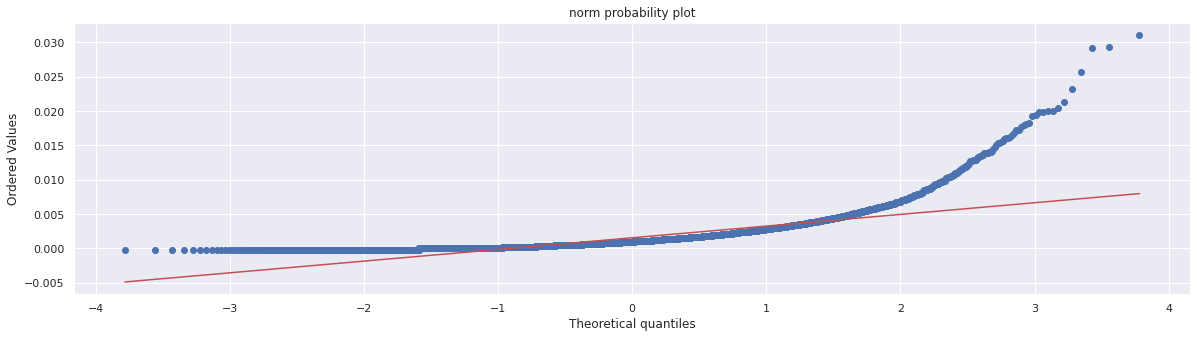

In [15]:
# Visualize the result
cplonorm.plot_qq(df_bnb["ret_spr_diff"])

# Deep dive into quantitative statistics #1805

## How much liquidity is available at the top of the book?

binance::ADA_USDT     1.737929e+07
binance::BNB_USDT     1.086384e+07
binance::BTC_USDT     7.362786e+06
binance::DOGE_USDT    8.017608e+06
binance::DOT_USDT     6.165297e+06
binance::EOS_USDT     1.439701e+06
binance::ETH_USDT     4.163328e+06
binance::LTC_USDT     1.065638e+07
binance::LUNA_USDT    1.614859e+06
binance::SOL_USDT     6.756251e+05
binance::UNI_USDT     1.852290e+06
binance::XRP_USDT     1.344421e+06
dtype: float64

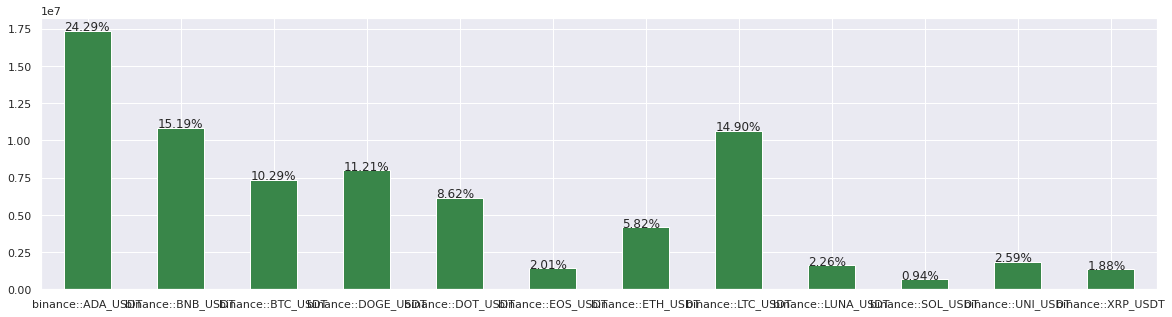

In [16]:
liquidity_stats = final_df["ask_value"].median()
display(liquidity_stats)
cplpluti.plot_barplot(liquidity_stats)

## Is the quoted spread constant over the day?

### One symbol

,quoted_spread,rets_volatility,trading_volume,relative_spread_bps,bid_ask_value,tradability,time
timestamp,,,,,,,
2022-01-01 00:00:00+00:00,0.001000,NaN,4624.5,3.296522,9.160270e+03,NaN,00:00:00
2022-01-01 00:10:00+00:00,0.001177,0.004189,92726.6,3.867689,5.441434e+06,0.000427,00:10:00
2022-01-01 00:20:00+00:00,0.001119,0.000464,48048.5,3.678479,5.417819e+06,0.000089,00:20:00


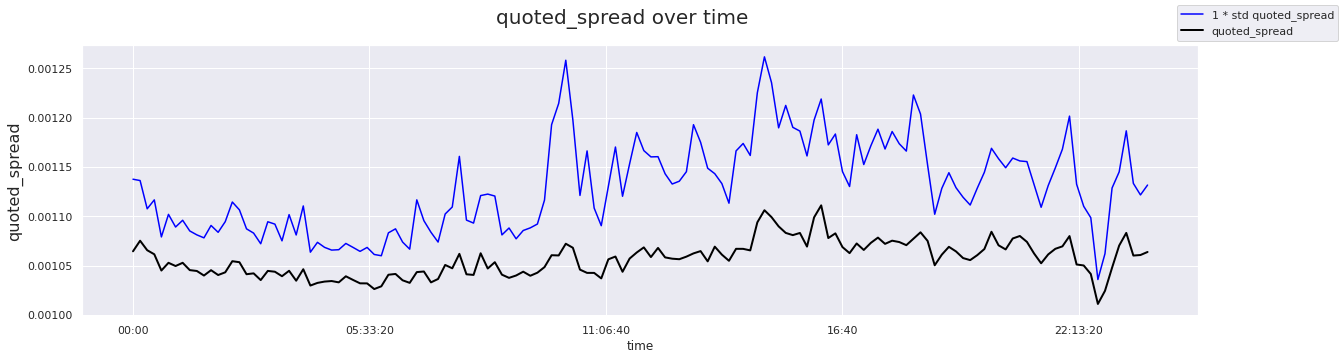

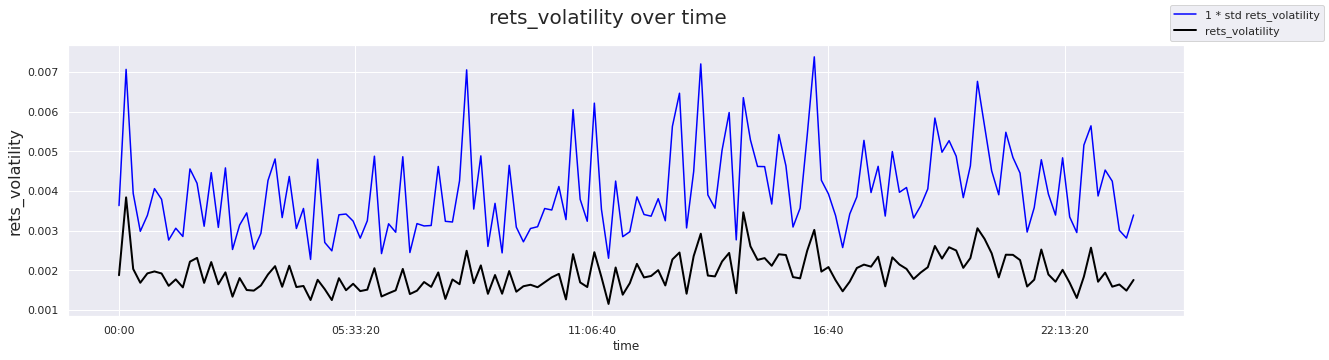

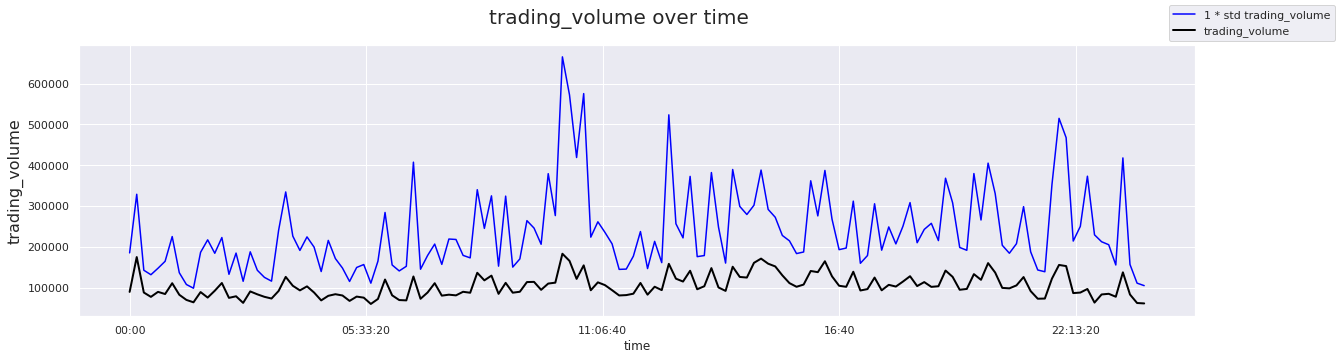

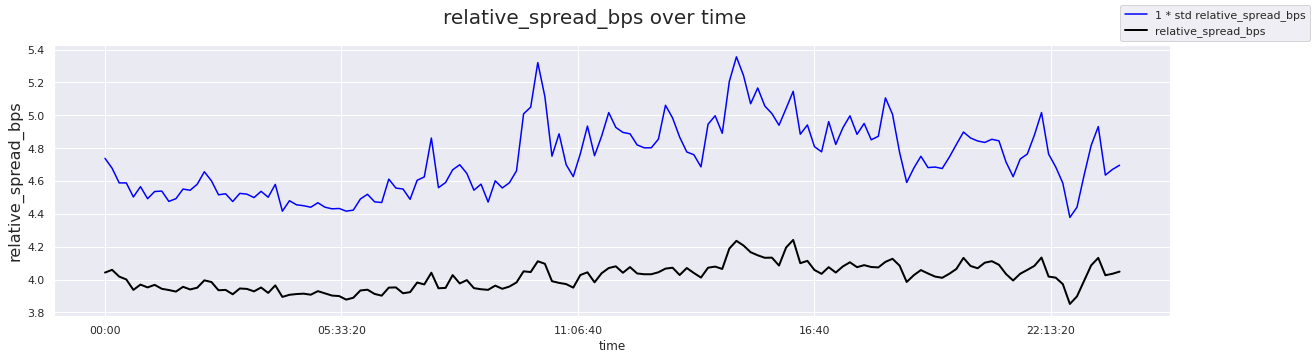

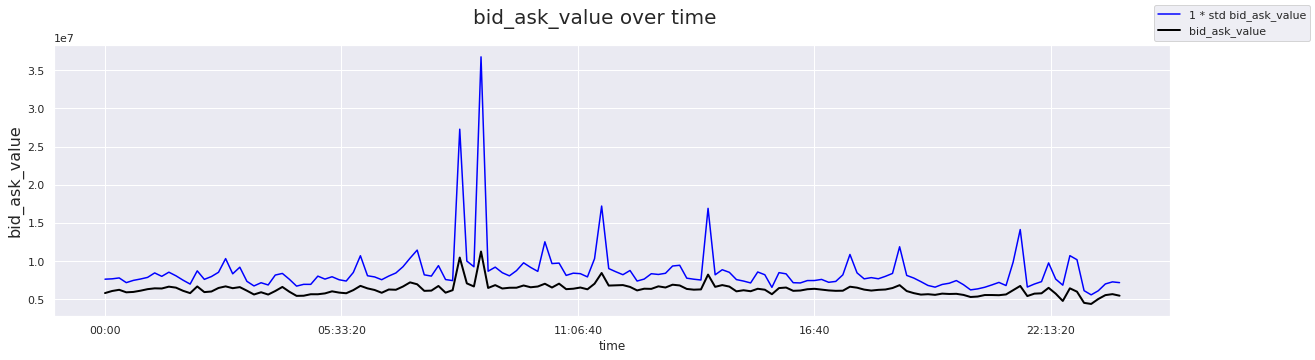

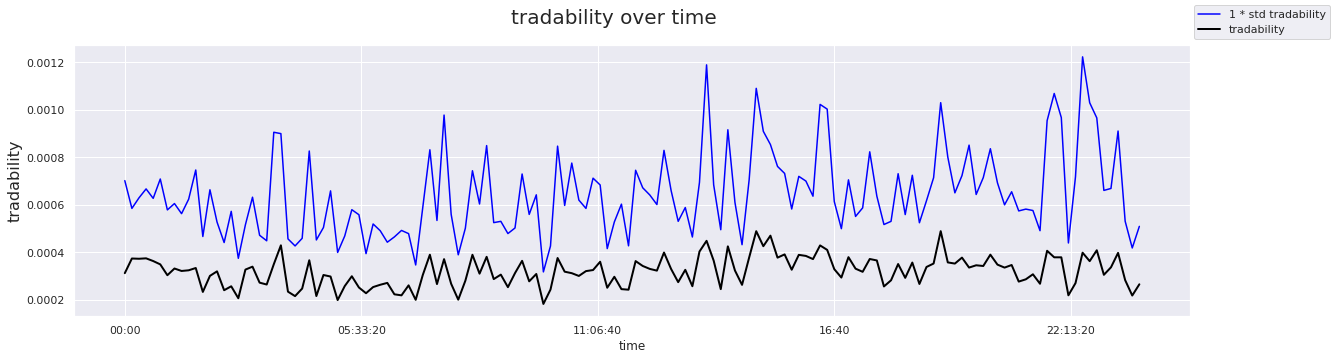

In [20]:
full_symbol = "binance::EOS_USDT"
resample_rule_stats = "10T"

stats_df = ramptran.calculate_overtime_quantities(
    final_df, full_symbol, resample_rule_stats
)
display(stats_df.head(3))

### Multiple Symbols

,quoted_spread,rets_volatility,trading_volume,relative_spread_bps,bid_ask_value,tradability,time,full_symbol
timestamp,,,,,,,,
2022-01-01 00:00:00+00:00,0.001000,NaN,98266.8,7.648184,6.898677e+04,NaN,00:00:00,binance::ADA_USDT
2022-01-01 00:10:00+00:00,0.001000,0.004855,1429630.6,7.605296,5.913979e+07,3.516066e-04,00:10:00,binance::ADA_USDT
2022-01-01 00:20:00+00:00,0.001003,0.001073,595061.1,7.623054,6.409698e+07,3.778678e-08,00:20:00,binance::ADA_USDT
2022-01-01 00:30:00+00:00,0.001000,0.003754,373268.4,7.578320,7.368927e+07,1.506698e-04,00:30:00,binance::ADA_USDT
2022-01-01 00:40:00+00:00,0.001000,0.000531,657083.6,7.566807,7.175373e+07,3.499599e-04,00:40:00,binance::ADA_USDT


bid_ask_value                                                                                                                                                                                                             quoted_spread                                                                                                                                                                                                         relative_spread_bps                                                                                                                                                                                                           rets_volatility                                                                                                                                                                                                                      time                                                                                                                                                                                                               tradability                                                                                                                                                                                                            trading_volume                                                                                                                                                                                                        
                          binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT   binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

bid_ask_value                                                                                                                                                                                                             quoted_spread                                                                                                                                                                                                         relative_spread_bps                                                                                                                                                                                                           rets_volatility                                                                                                                                                                                                               tradability                                                                           \
                 binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT   binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT binance::EOS_USDT binance::ETH_USDT binance::LTC_USDT binance::LUNA_USDT binance::SOL_USDT binance::UNI_USDT binance::XRP_USDT binance::ADA_USDT binance::BNB_USDT binance::BTC_USDT binance::DOGE_USDT binance::DOT_USDT   
time_inside_days                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
00:00:00              6.472766e+07      3.690833e+07      2.729707e+07       3.129980e+07      2.116721e+07      5.763491e+06      1.782736e+07      3.896465e+07       6.596529e+06      2.593027e+06      7.893526e+06      4.734216e+06             0.001          0.100169          0.108707             0.0001          0.010017          0.001037          0.042004          0.100000           0.015316          0.017118          0.011625          0.000101            8.190060          2.203811          0.025665           6.474311          4.046999          3.773529          0.125816          7.622034           2.337117          1.413887          7.727438          1.340841          0.002897          0.001143          0.001017           0.001979          0.002734          0.001305          0.001378          0.001305           0.002627          0.002438          0.002483          0.001501          0.000200          0.000398          0.024026           0.000200          0.000335   
00:10:00              5.993608e+07      4.160591e+07      3.106676e+07       2.96

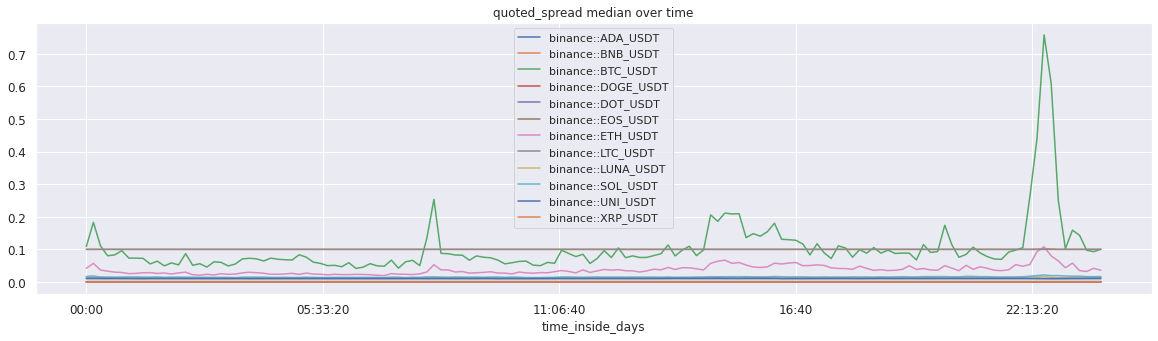

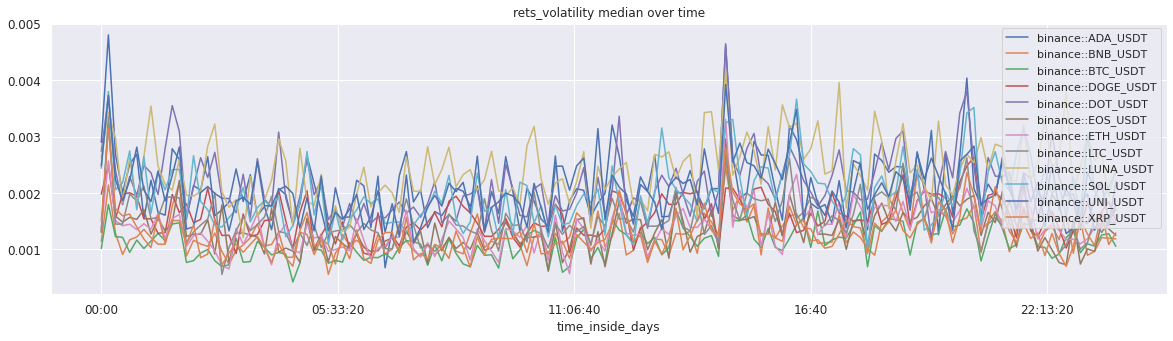

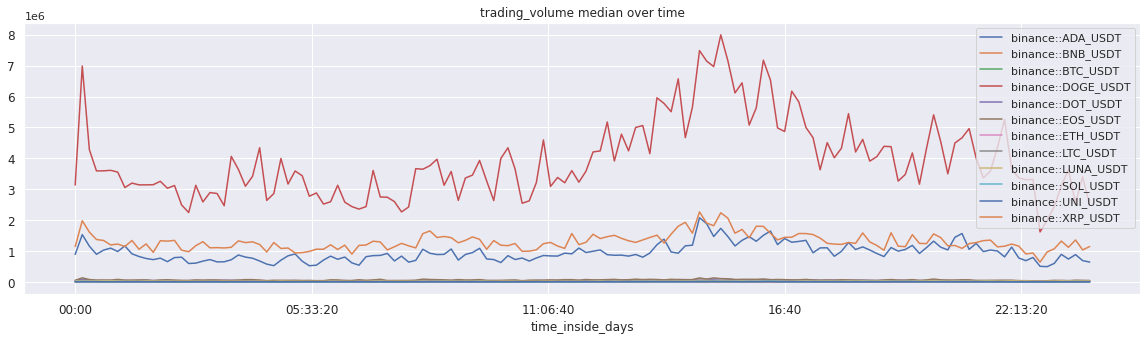

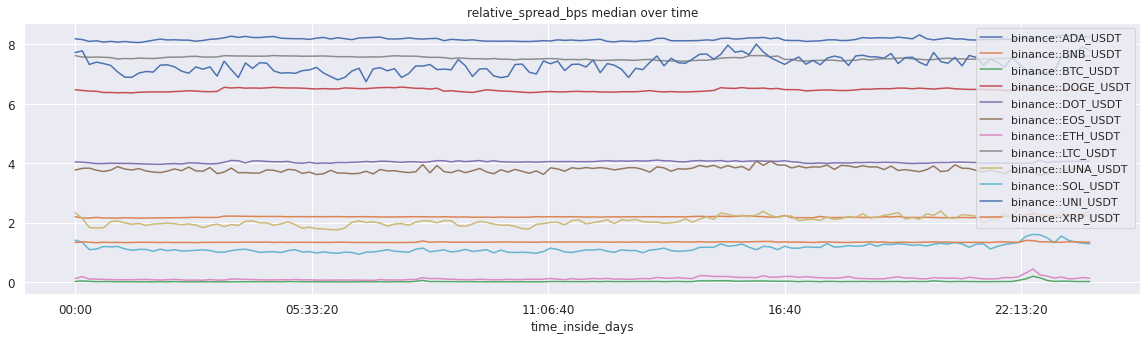

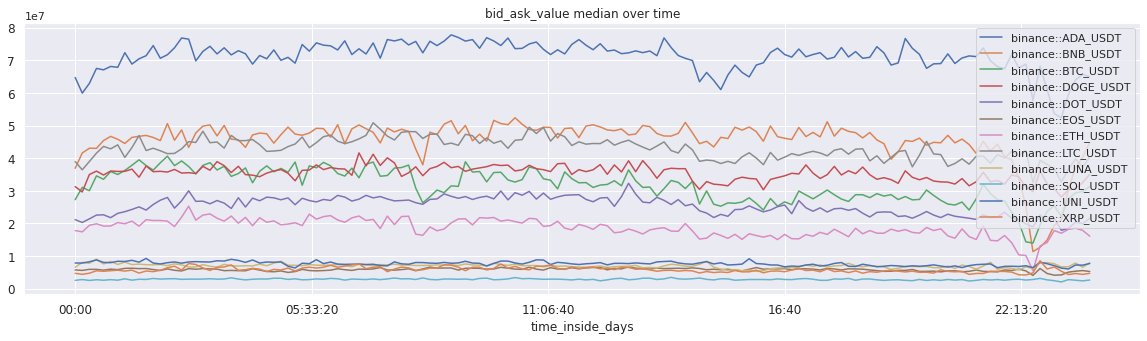

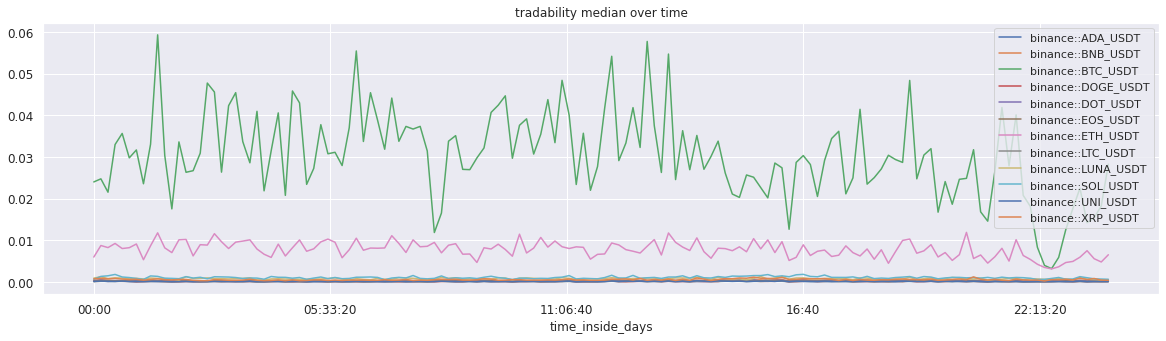

In [18]:
full_symbols = config["data"]["full_symbols"]
resample_rule_stats = "10T"

stats_df_mult_symbols = ramptran.calculate_overtime_quantities_multiple_symbols(
    final_df, full_symbols, resample_rule_stats
)
display(stats_df_mult_symbols.head(3))

## - Compute some high-level stats (e.g., median relative spread, median bid / ask notional, volatility, volume) by coins

In [19]:
high_level_stats = pd.DataFrame()
high_level_stats["median_relative_spread"] = final_df[
    "relative_spread_bps"
].median()
high_level_stats["median_notional_bid"] = final_df["bid_value"].median()
high_level_stats["median_notional_ask"] = final_df["ask_value"].median()
high_level_stats["median_notional_volume"] = (
    final_df["volume"] * final_df["close"]
).median()
high_level_stats["volatility_per_period"] = (
    final_df["close.ret_0"].std() * final_df.shape[0] ** 0.5
)

display(high_level_stats)

,median_relative_spread,median_notional_bid,median_notional_ask,median_notional_volume,volatility_per_period
binance::ADA_USDT,8.172696,1.670557e+07,1.737929e+07,5.326366e+05,0.380244
binance::BNB_USDT,2.198768,1.111678e+07,1.086384e+07,9.454839e+05,0.257917
binance::BTC_USDT,0.020428,7.387572e+06,7.362786e+06,3.698643e+06,0.214720
binance::DOGE_USDT,6.453460,8.779991e+06,8.017608e+06,2.757246e+05,0.371310
binance::DOT_USDT,4.049680,5.884022e+06,6.165297e+06,5.359453e+05,0.383510
binance::EOS_USDT,3.781081,1.395272e+06,1.439701e+06,7.824819e+04,0.278799
binance::ETH_USDT,0.112242,4.291457e+06,4.163328e+06,2.825296e+06,0.281932
binance::LTC_USDT,7.540397,9.711905e+06,1.065638e+07,1.496346e+05,0.313953
binance::LUNA_USDT,2.052706,1.633936e+06,1.614859e+06,9.473899e+05,0.442859
binance::SOL_USDT,1.128847,6.596016e+05,6.756251e+05,5.900585e+05,0.404208
